# Visual Verification: FID Loader and Processing Pipeline

```{warning} **Work in Progress 🚧**
``` 

**Goal:** Visually verify the strict 1D-to-ND Bruker memory reshaping, physical coordinate calculation, and the newly refactored `xmris` processing pipeline. We will explicitly use `xarray`'s native plotting to ensure units and axis names are automatically and correctly resolved.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# High-res output for crisp visual inspection
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 150

In [2]:
from pathlib import Path
import xarray as xr

from xmris.vendor.bruker import reshape_bruker_raw, build_fid
from xmris.core.config import DIMS, COORDS

# Configuration
xr.set_options(display_expand_data=False)


## 1. Data Loading and Reshaping

Raw Bruker data is read as a continuous 1D array. To make it useful, we must reshape it into an N-dimensional C-contiguous array based on the acquisition parameters, and then wrap it in an `xarray.DataArray` with the correct physical coordinates.

In [3]:
DATA_DIR = Path("../../../tests/data/")
FILE_PATH = Path(DATA_DIR / "nspect_slab_1H" / "rawdatajob0.nc")

# Load the raw 1D complex data
raw_1d_data = xr.load_dataarray(FILE_PATH).xmr.to_complex()

# Reshape into C-contiguous N-dimensional numpy array
reshaped_nd, valid_dims = reshape_bruker_raw(raw_1d_data.values, raw_1d_data.attrs)

# Construct the FID DataArray
fid_xr = build_fid(reshaped_nd, valid_dims, raw_1d_data.attrs)

print(f"Constructed FID Shape: {fid_xr.shape}")
print(f"Assigned Attributes: {list(fid_xr.attrs.keys())}")


Reshaped Bruker data to dims: [ time | averages ]
Constructed FID Shape: (2048, 5)
Assigned Attributes: ['reference_frequency', 'carrier_ppm', 'bruker_group_delay', 'units']


## 2. Inspecting the Time Domain (FID)

To simplify our visual inspection, we will select the first repetition, channel, or average if the data is multi-dimensional. We then plot the Free Induction Decay (FID) to verify signal decay shape, complex quadrature, and the absence of truncation artifacts.

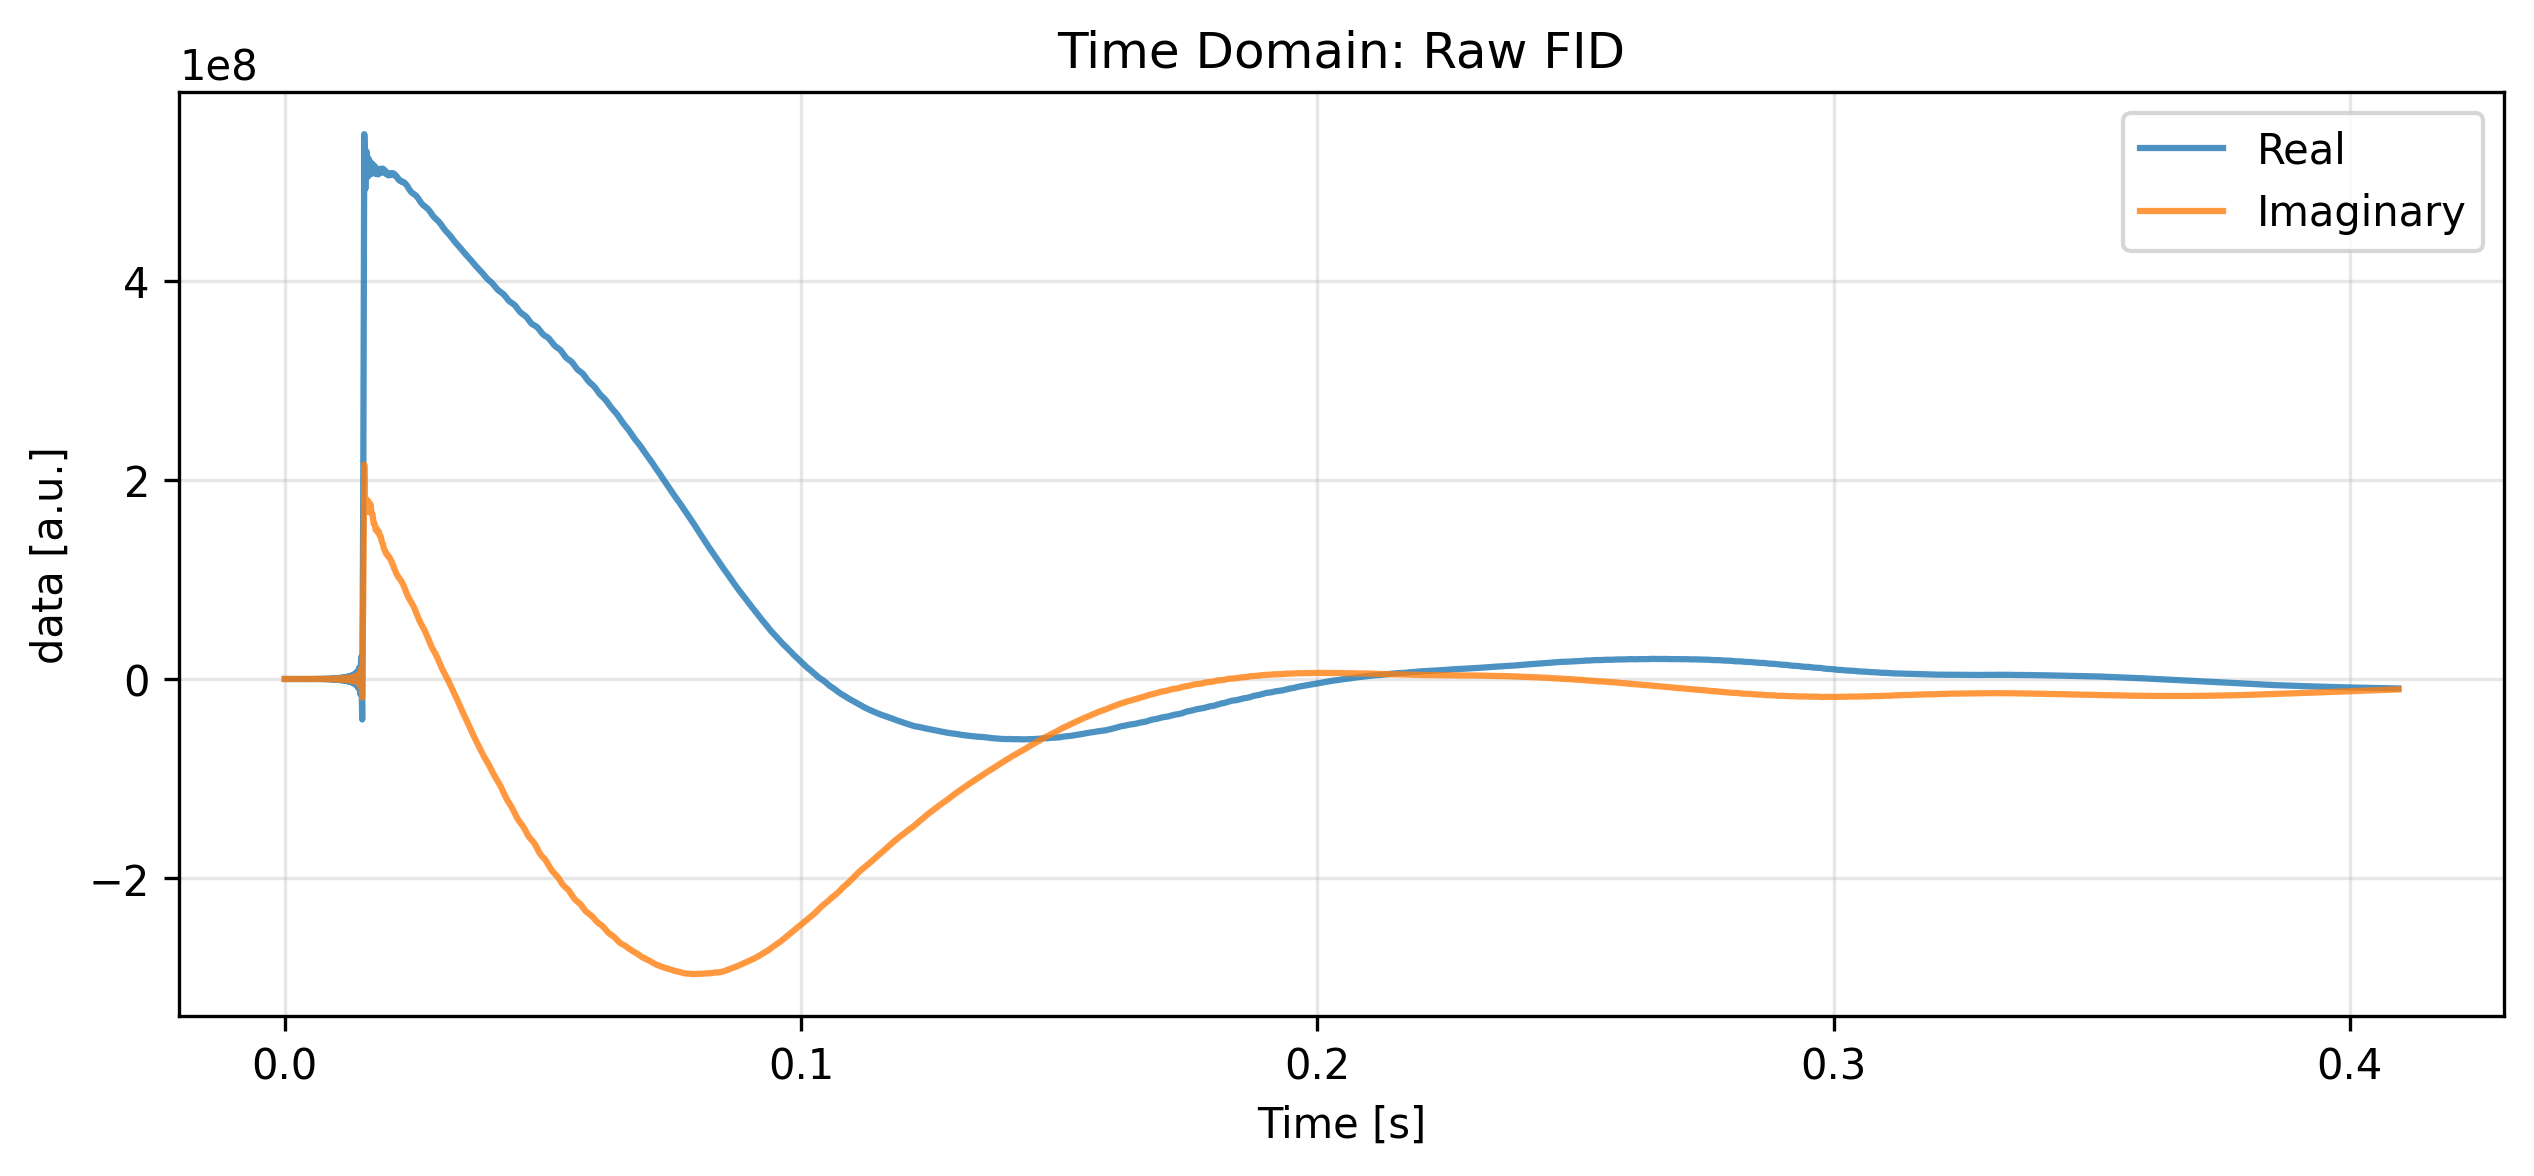

In [4]:
# Select a 1D slice for basic visual inspection if multi-dimensional
if fid_xr.ndim > 1:
    fid_inspect = fid_xr.isel({d: 0 for d in fid_xr.dims if d != DIMS.time})
else:
    fid_inspect = fid_xr

fig, ax = plt.subplots(figsize=(10, 4))

# Use xarray's native plotting to verify automatic labels
fid_inspect.real.plot(ax=ax, label="Real", alpha=0.8)
fid_inspect.imag.plot(ax=ax, label="Imaginary", alpha=0.8)

ax.set_title("Time Domain: Raw FID")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


### Removing the Digital Filter

Bruker spectrometers utilize digital filters that introduce a group delay at the beginning of the FID. We use the `remove_digital_filter` accessor to correct this, relying on the `groupDelay` attribute from the metadata.

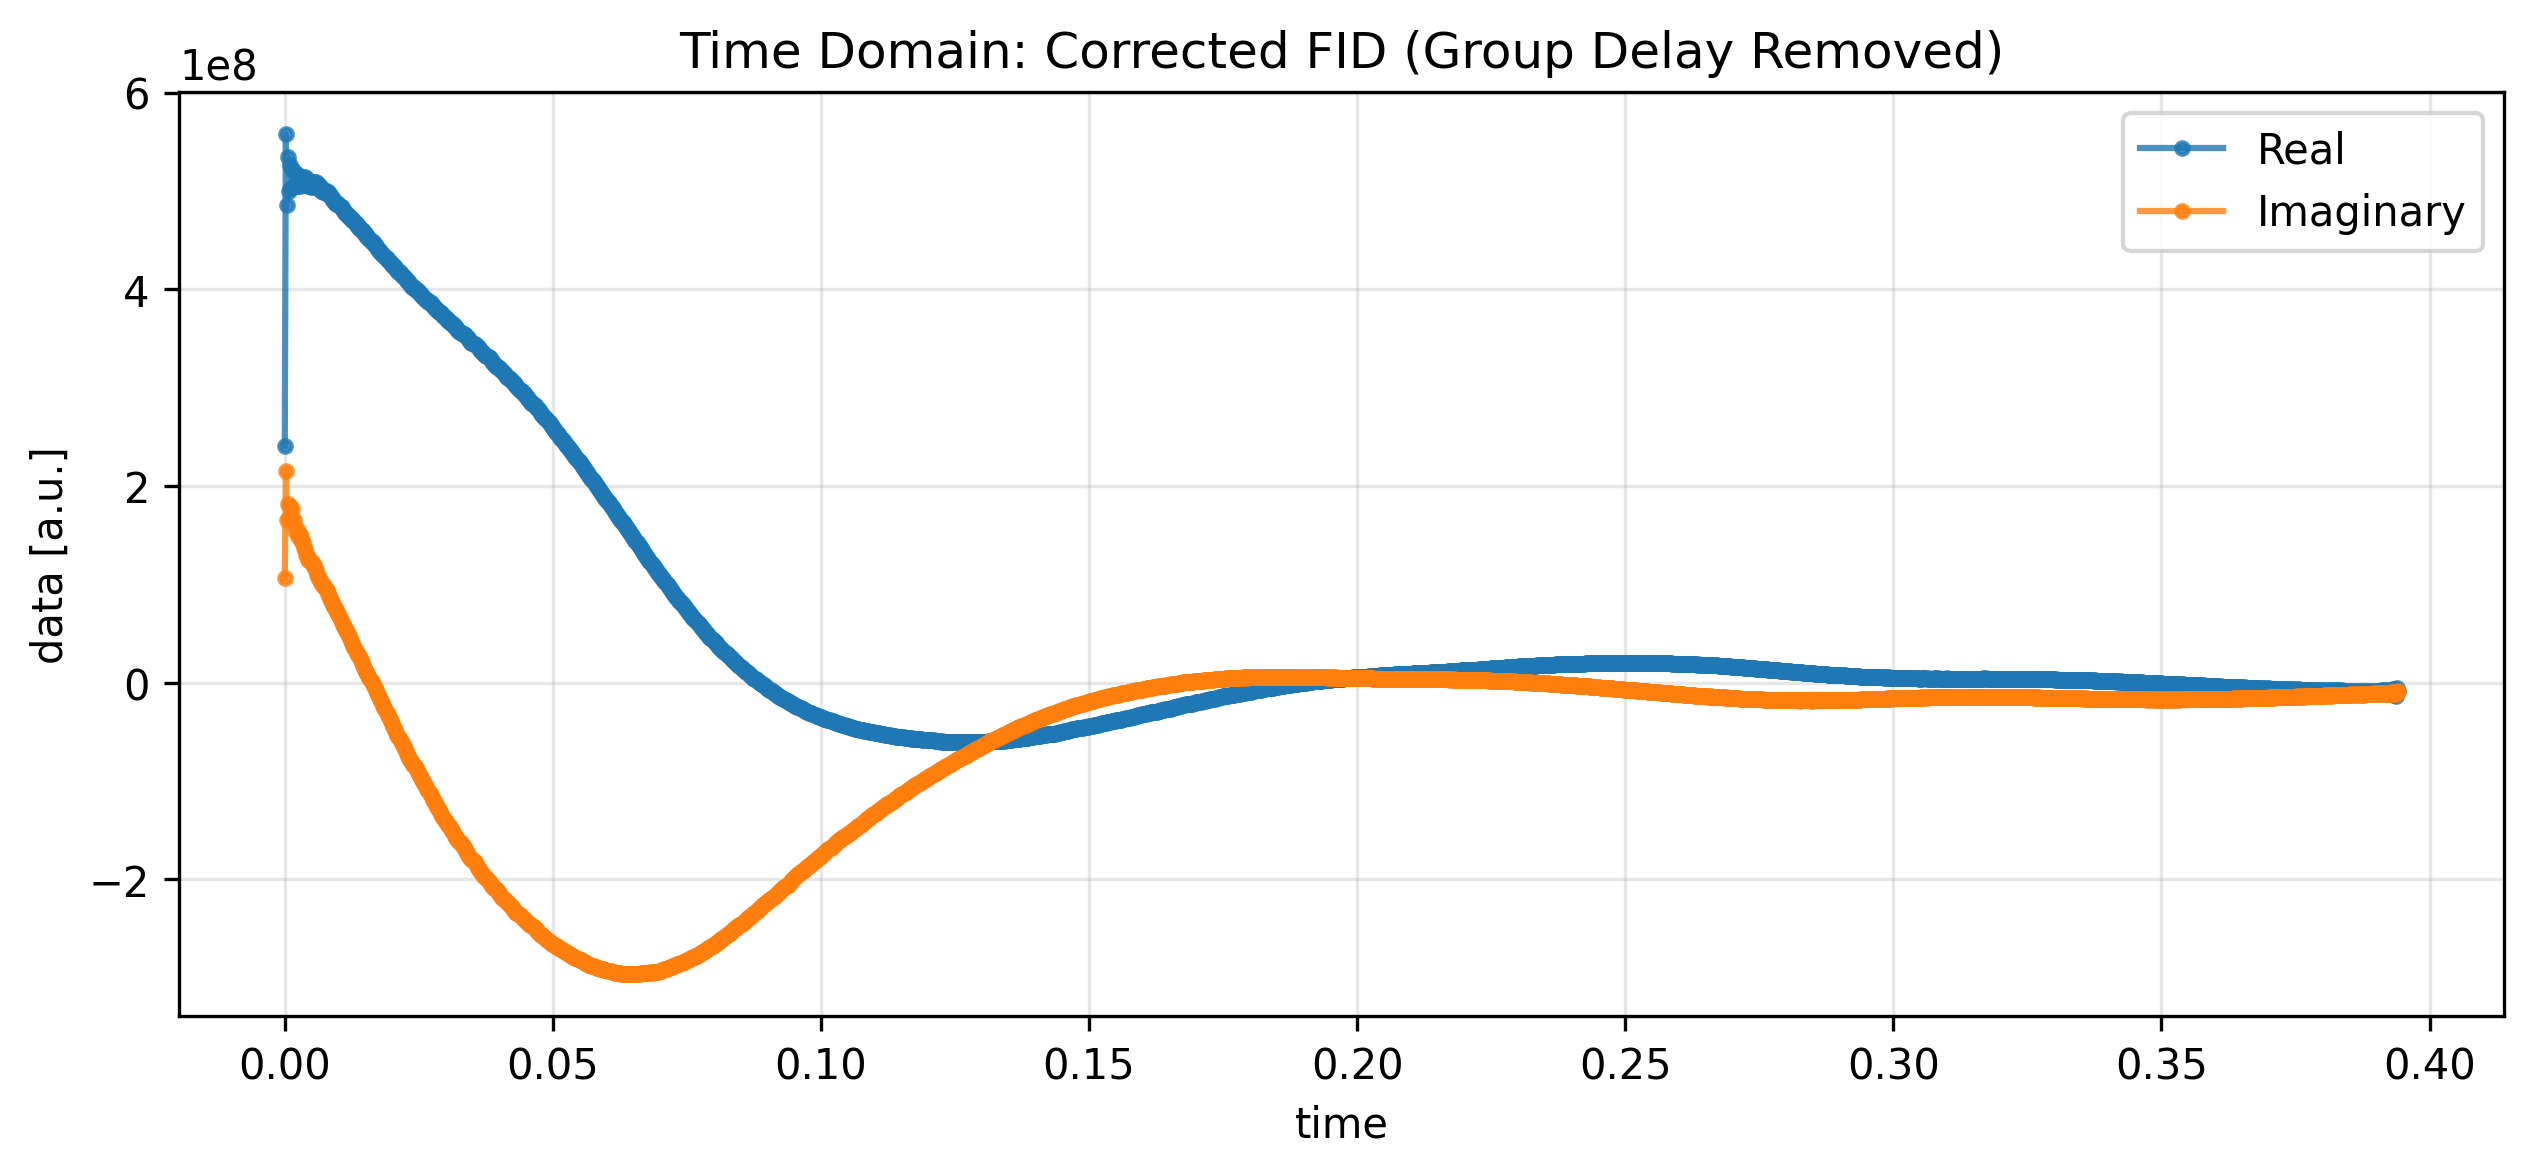

In [ ]:
# Remove group delay
fid_corrected = fid_inspect.xmr.remove_digital_filter(
    group_delay=raw_1d_data.attrs["groupDelay"],
    keep_length=False
)

fig, ax = plt.subplots(figsize=(10, 4))

fid_corrected.real.plot(ax=ax, label="Real", alpha=0.8, marker='.')
fid_corrected.imag.plot(ax=ax, label="Imaginary", alpha=0.8, marker='.')

ax.set_title("Time Domain: Corrected FID (Group Delay Removed)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## 3. The `xmris` Spectral Pipeline

With the FID corrected, we can pass it through the `xmris` processing pipeline. Here, we apply an exponential apodization to smooth the signal, transform it to the frequency domain, and automatically correct the phase.

In [14]:
# Apply the strict xmris pipeline
spectrum = (
    fid_corrected
    # .xmr.apodize_exp(lb=2)
    .xmr.to_spectrum()
    .xmr.autophase()
)

spectrum


<xarray.DataArray (frequency: 1972)> Size: 32kB
(4917052.170119479+2388750.292483922j) ... (5327541.072752285-1140170.8006153...
Coordinates:
    averages   int64 8B 0
  * frequency  (frequency) float64 16kB -2.5e+03 -2.497e+03 ... 2.497e+03
Attributes:
    reference_frequency:         127.6261421047187
    carrier_ppm:                 4.7
    bruker_group_delay:          76.125
    units:                       a.u.
    digital_filter_removed:      True
    group_delay_removed:         76.125
    length_retained_with_zeros:  False
    phase_p0:                    -16.719255953556267
    phase_p1:                    275.9234615762676
    phase_pivot:                 -5.070993914807289
    phase_pivot_coord:           frequency

### Visualizing the Frequency Domain

We can visualize the resulting spectrum. Note how `xarray` automatically handles the coordinate labels. We invert the x-axis to adhere to standard NMR/MRI conventions.

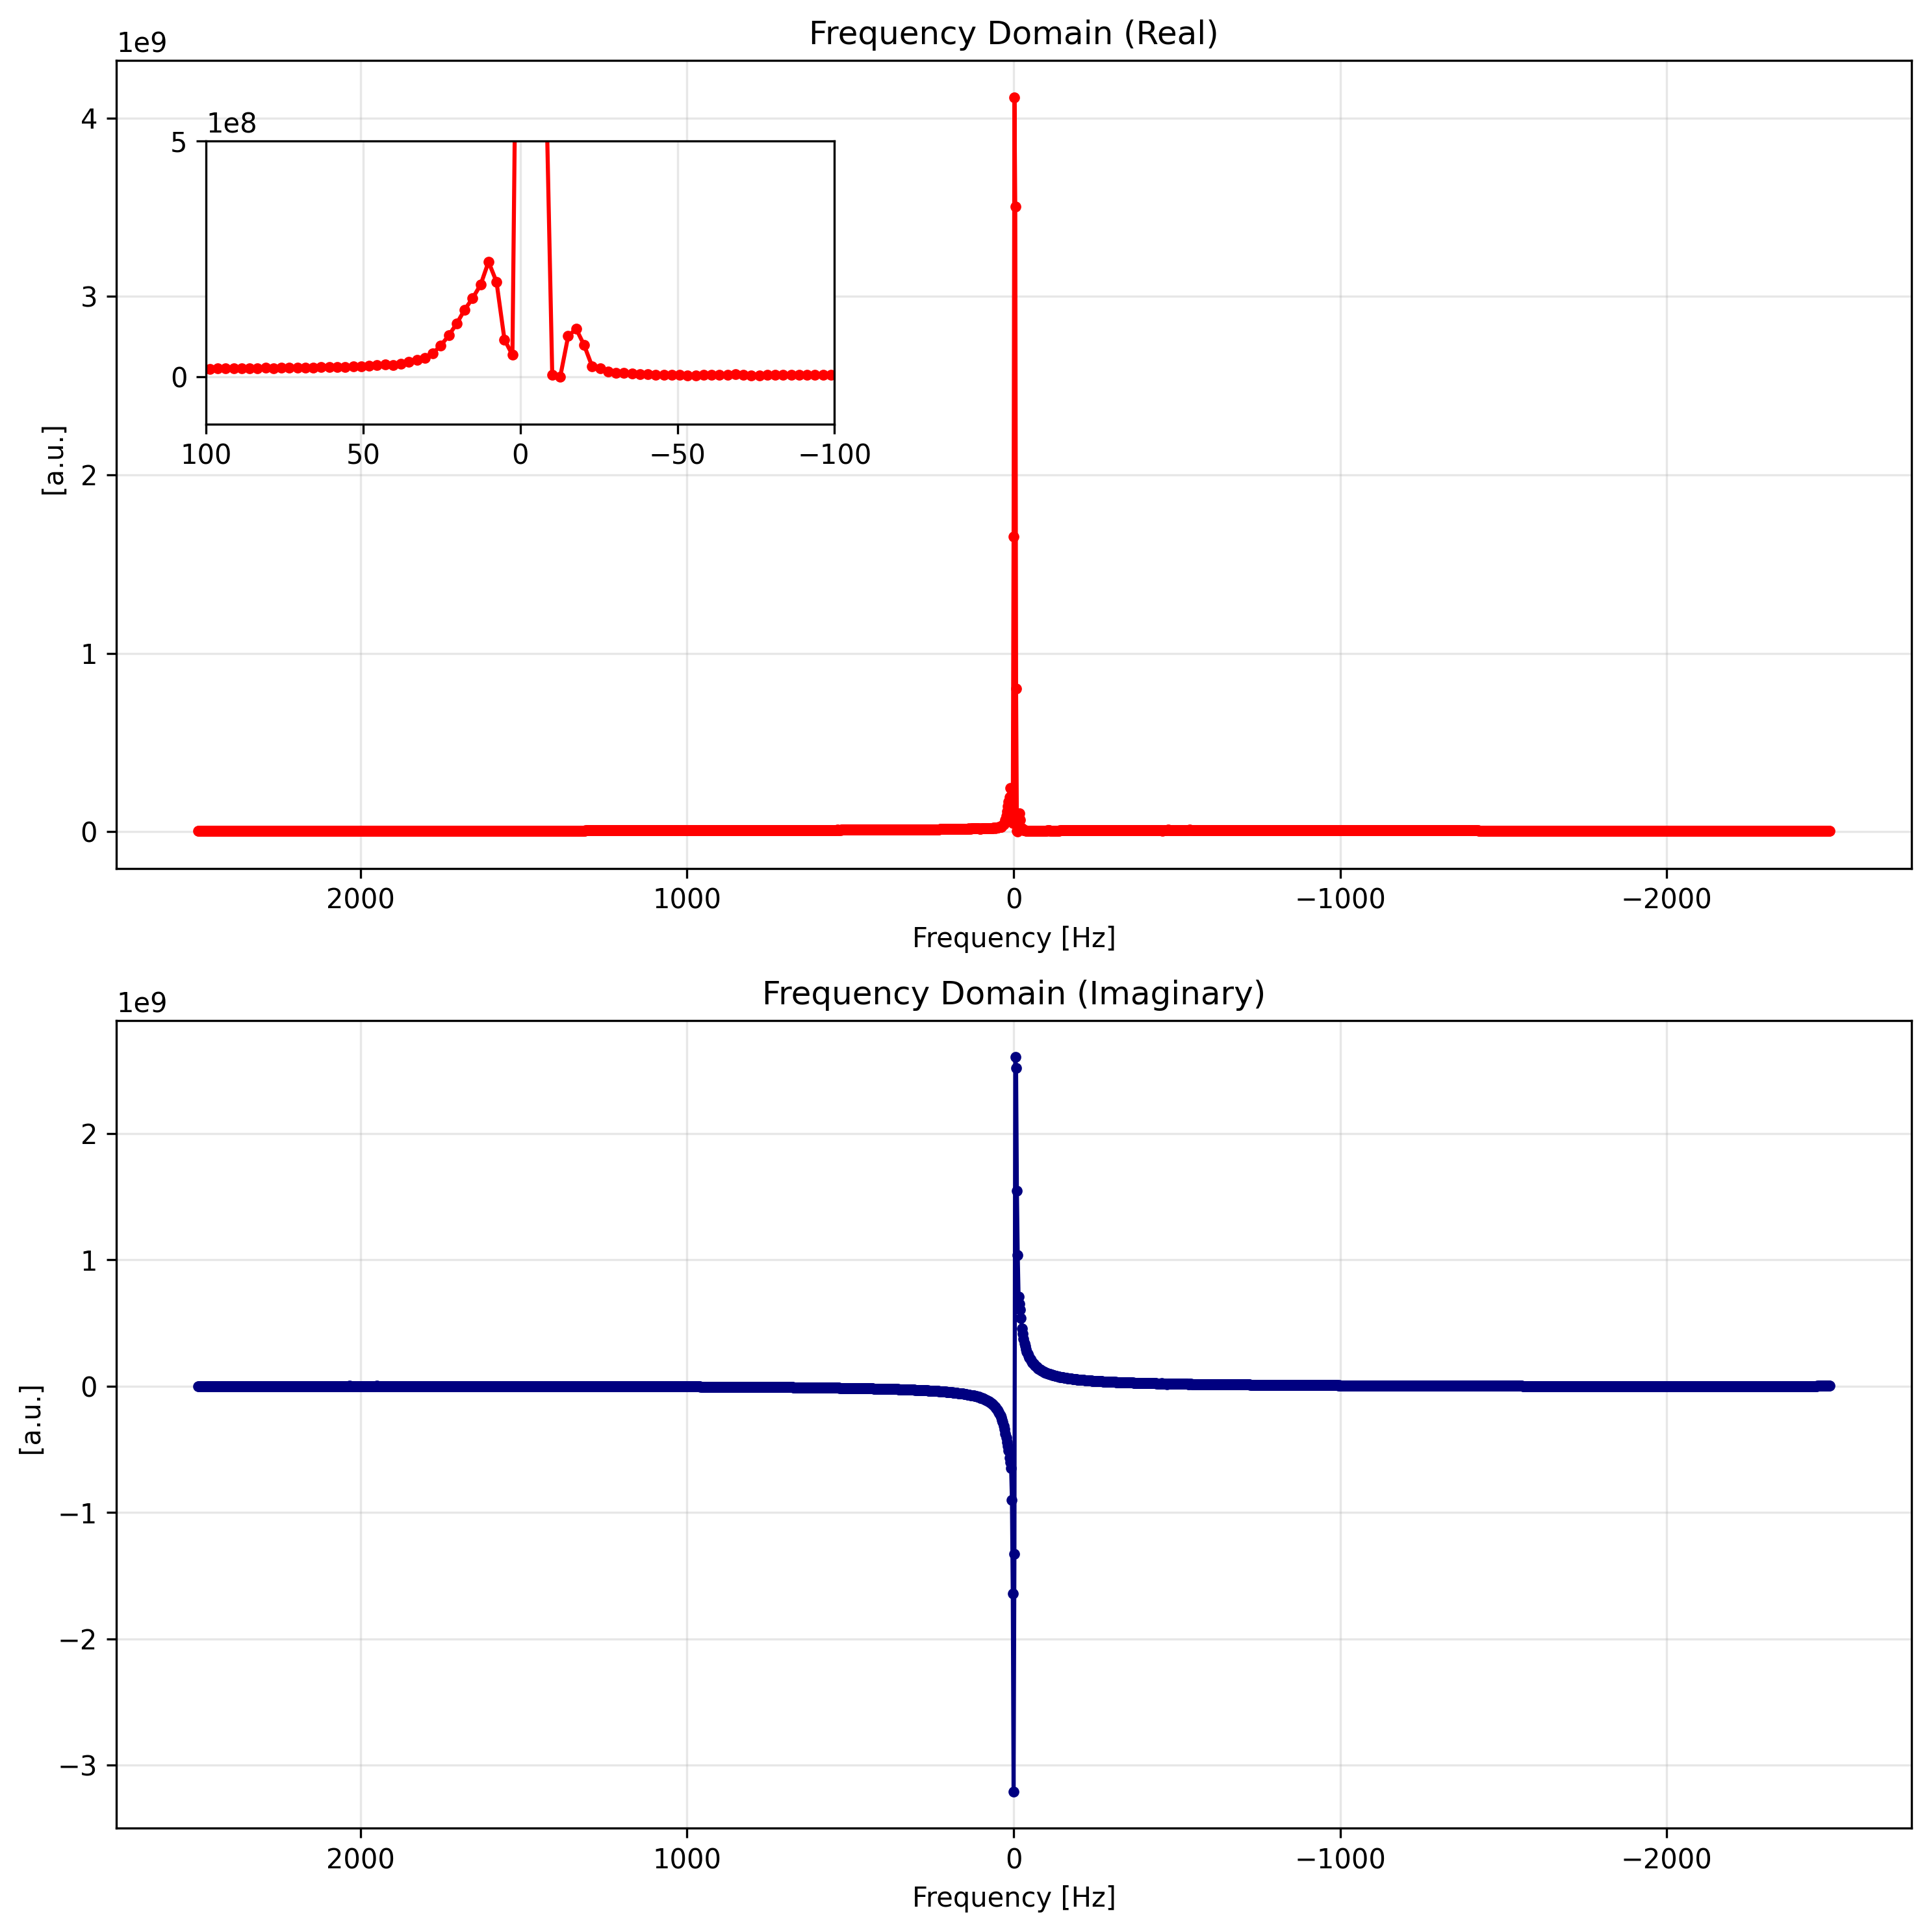

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# --- Subplot 1: Real Component ---
spectrum.real.plot(ax=ax1, color="red", marker='.')
ax1.set_title("Frequency Domain (Real)")
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_inverted(True)

# --- Inlay Plot for Subplot 1 (Top Left) ---
# [x, y, width, height] in normalized axes coordinates (0 to 1)
axins = ax1.inset_axes([0.05, 0.55, 0.35, 0.35])
spectrum.real.plot(ax=axins, color="red", marker='.')

# Set limits for the zoom (x-axis inverted to match the main plot)
axins.set_xlim(100, -100)
axins.set_ylim(-1e8, 0.5e9) # Keeping a slight negative baseline so the peak doesn't float

# Clean up inset labels so it doesn't clutter the main plot
axins.set_title('')
axins.set_xlabel('')
axins.set_yticks([0, 0.5e9])
axins.set_ylabel('')
axins.grid(True, alpha=0.3)

# Draw connecting lines from the inset to the zoomed region
# ax1.indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# --- Subplot 2: Imaginary Component ---
spectrum.imag.plot(ax=ax2, color="navy", marker='.')
ax2.set_title("Frequency Domain (Imaginary)")
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_inverted(True)

plt.tight_layout()
plt.show()

## 4. Chemical Shift Conversion

For chemical analysis, viewing the spectrum in parts per million (ppm) is more useful than raw Hertz. The `.xmr.to_ppm()` accessor handles this conversion automatically using the spectrometer frequency metadata.

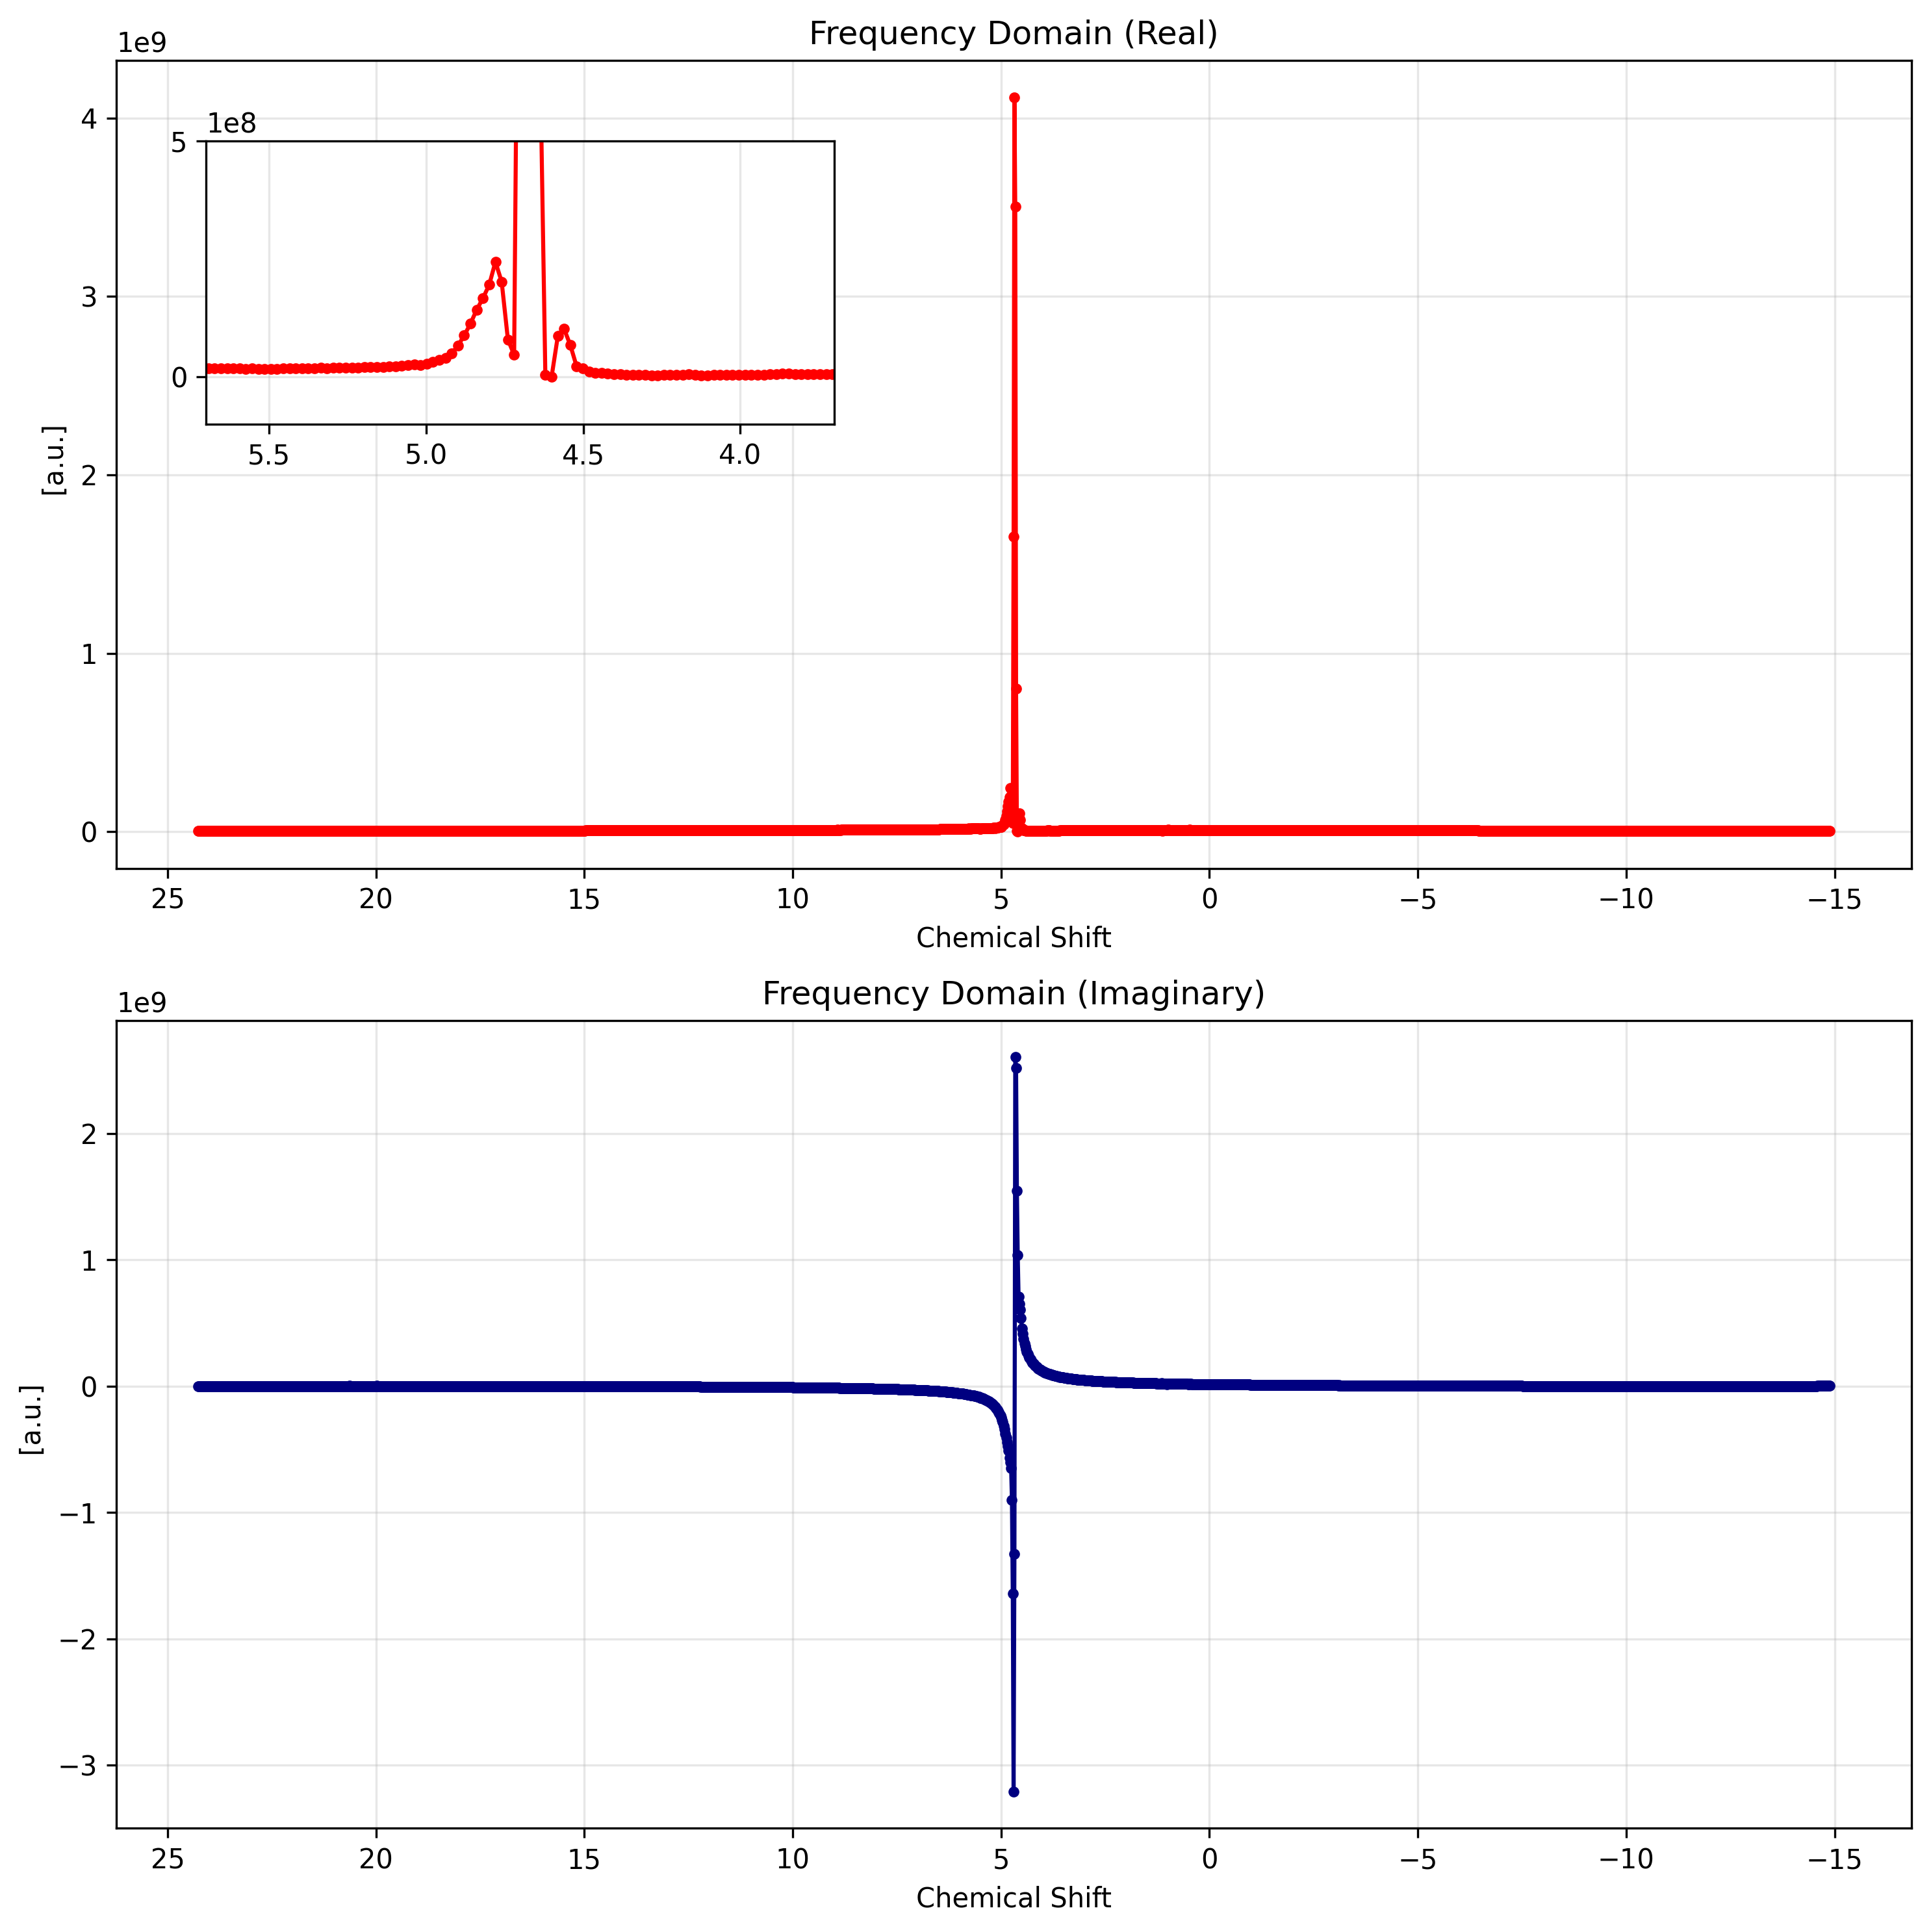

In [58]:
# Convert frequency to chemical shift (ppm)
spectrum_ppm = spectrum.xmr.to_ppm()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# --- Subplot 1: Real Component ---
spectrum_ppm.real.plot(ax=ax1, color="red", marker='.')
ax1.set_title("Frequency Domain (Real)")
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_inverted(True)

# --- Inlay Plot for Subplot 1 (Top Left) ---
# [x, y, width, height] in normalized axes coordinates (0 to 1)
axins = ax1.inset_axes([0.05, 0.55, 0.35, 0.35])
spectrum_ppm.real.plot(ax=axins, color="red", marker='.')

# Set limits for the zoom (x-axis inverted to match the main plot)
axins.set_xlim(5.7, 3.7)
axins.set_ylim(-1e8, 0.5e9) # Keeping a slight negative baseline so the peak doesn't float

# Clean up inset labels so it doesn't clutter the main plot
axins.set_title('')
axins.set_xlabel('')
axins.set_yticks([0, 0.5e9])
axins.set_ylabel('')
axins.grid(True, alpha=0.3)

# Draw connecting lines from the inset to the zoomed region
# ax1.indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# --- Subplot 2: Imaginary Component ---
spectrum_ppm.imag.plot(ax=ax2, color="navy", marker='.')
ax2.set_title("Frequency Domain (Imaginary)")
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_inverted(True)

plt.tight_layout()
plt.show()

## 5. Reverse Transformation

The `xmris` accessors preserve metadata and coordinates perfectly, allowing seamless reverse transformations. We can convert our processed spectrum back into the time domain using `.xmr.to_fid()`.

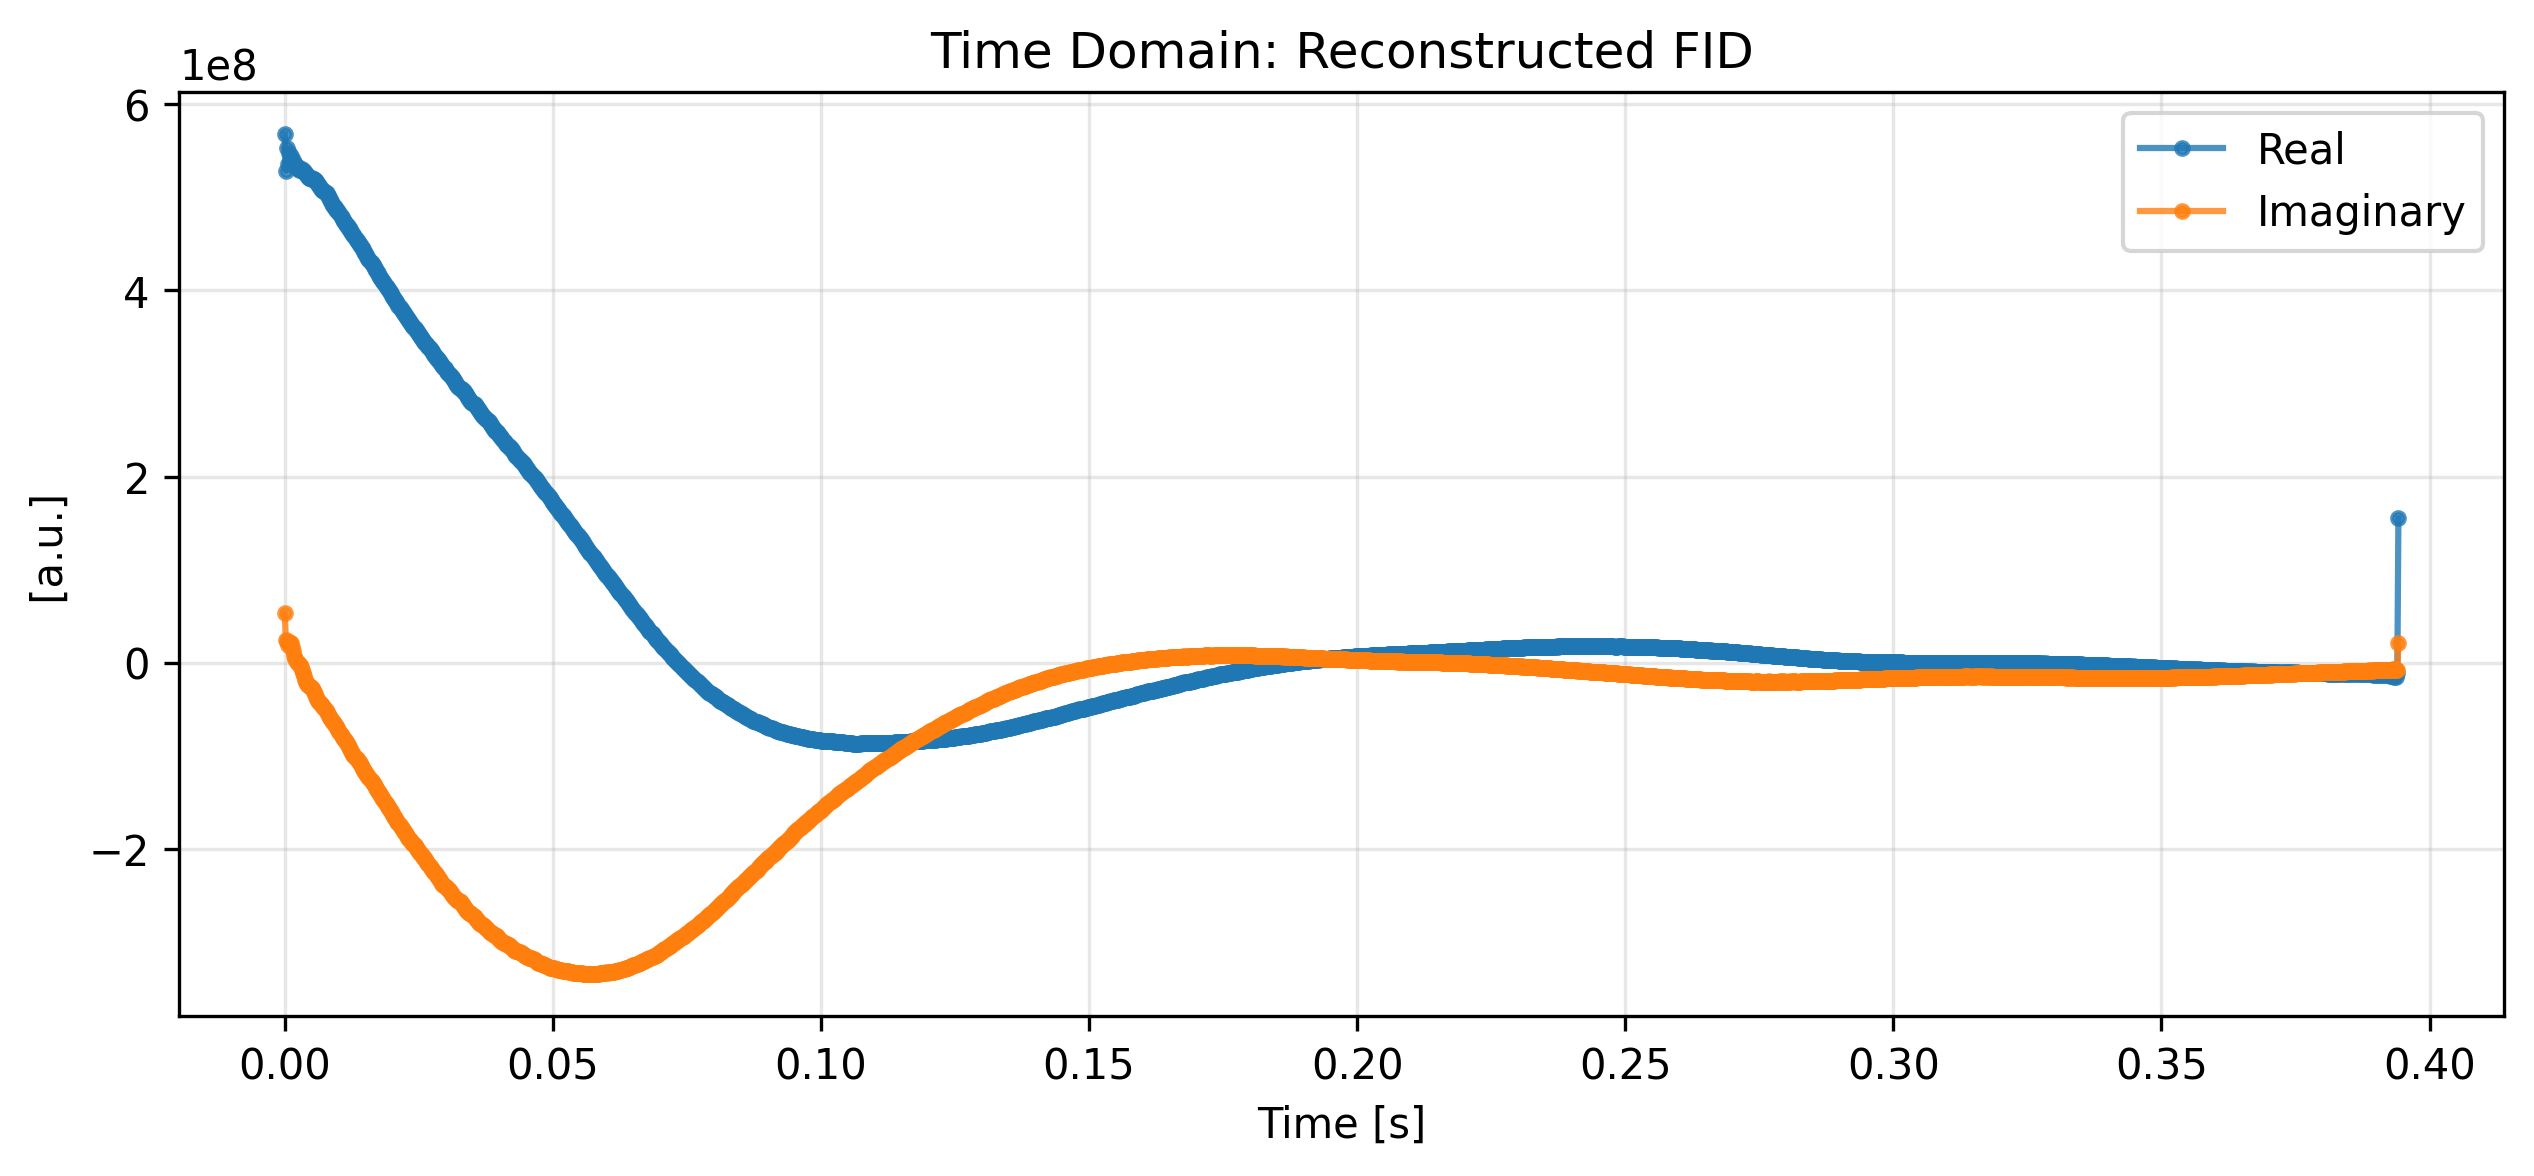

In [17]:
# Inverse Fourier Transform back to Time Domain
fid_final = spectrum.xmr.to_fid()

fig, ax = plt.subplots(figsize=(10, 4))

fid_final.real.plot(ax=ax, label="Real", alpha=0.8, marker='.')
fid_final.imag.plot(ax=ax, label="Imaginary", alpha=0.8, marker='.')

ax.set_title("Time Domain: Reconstructed FID")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


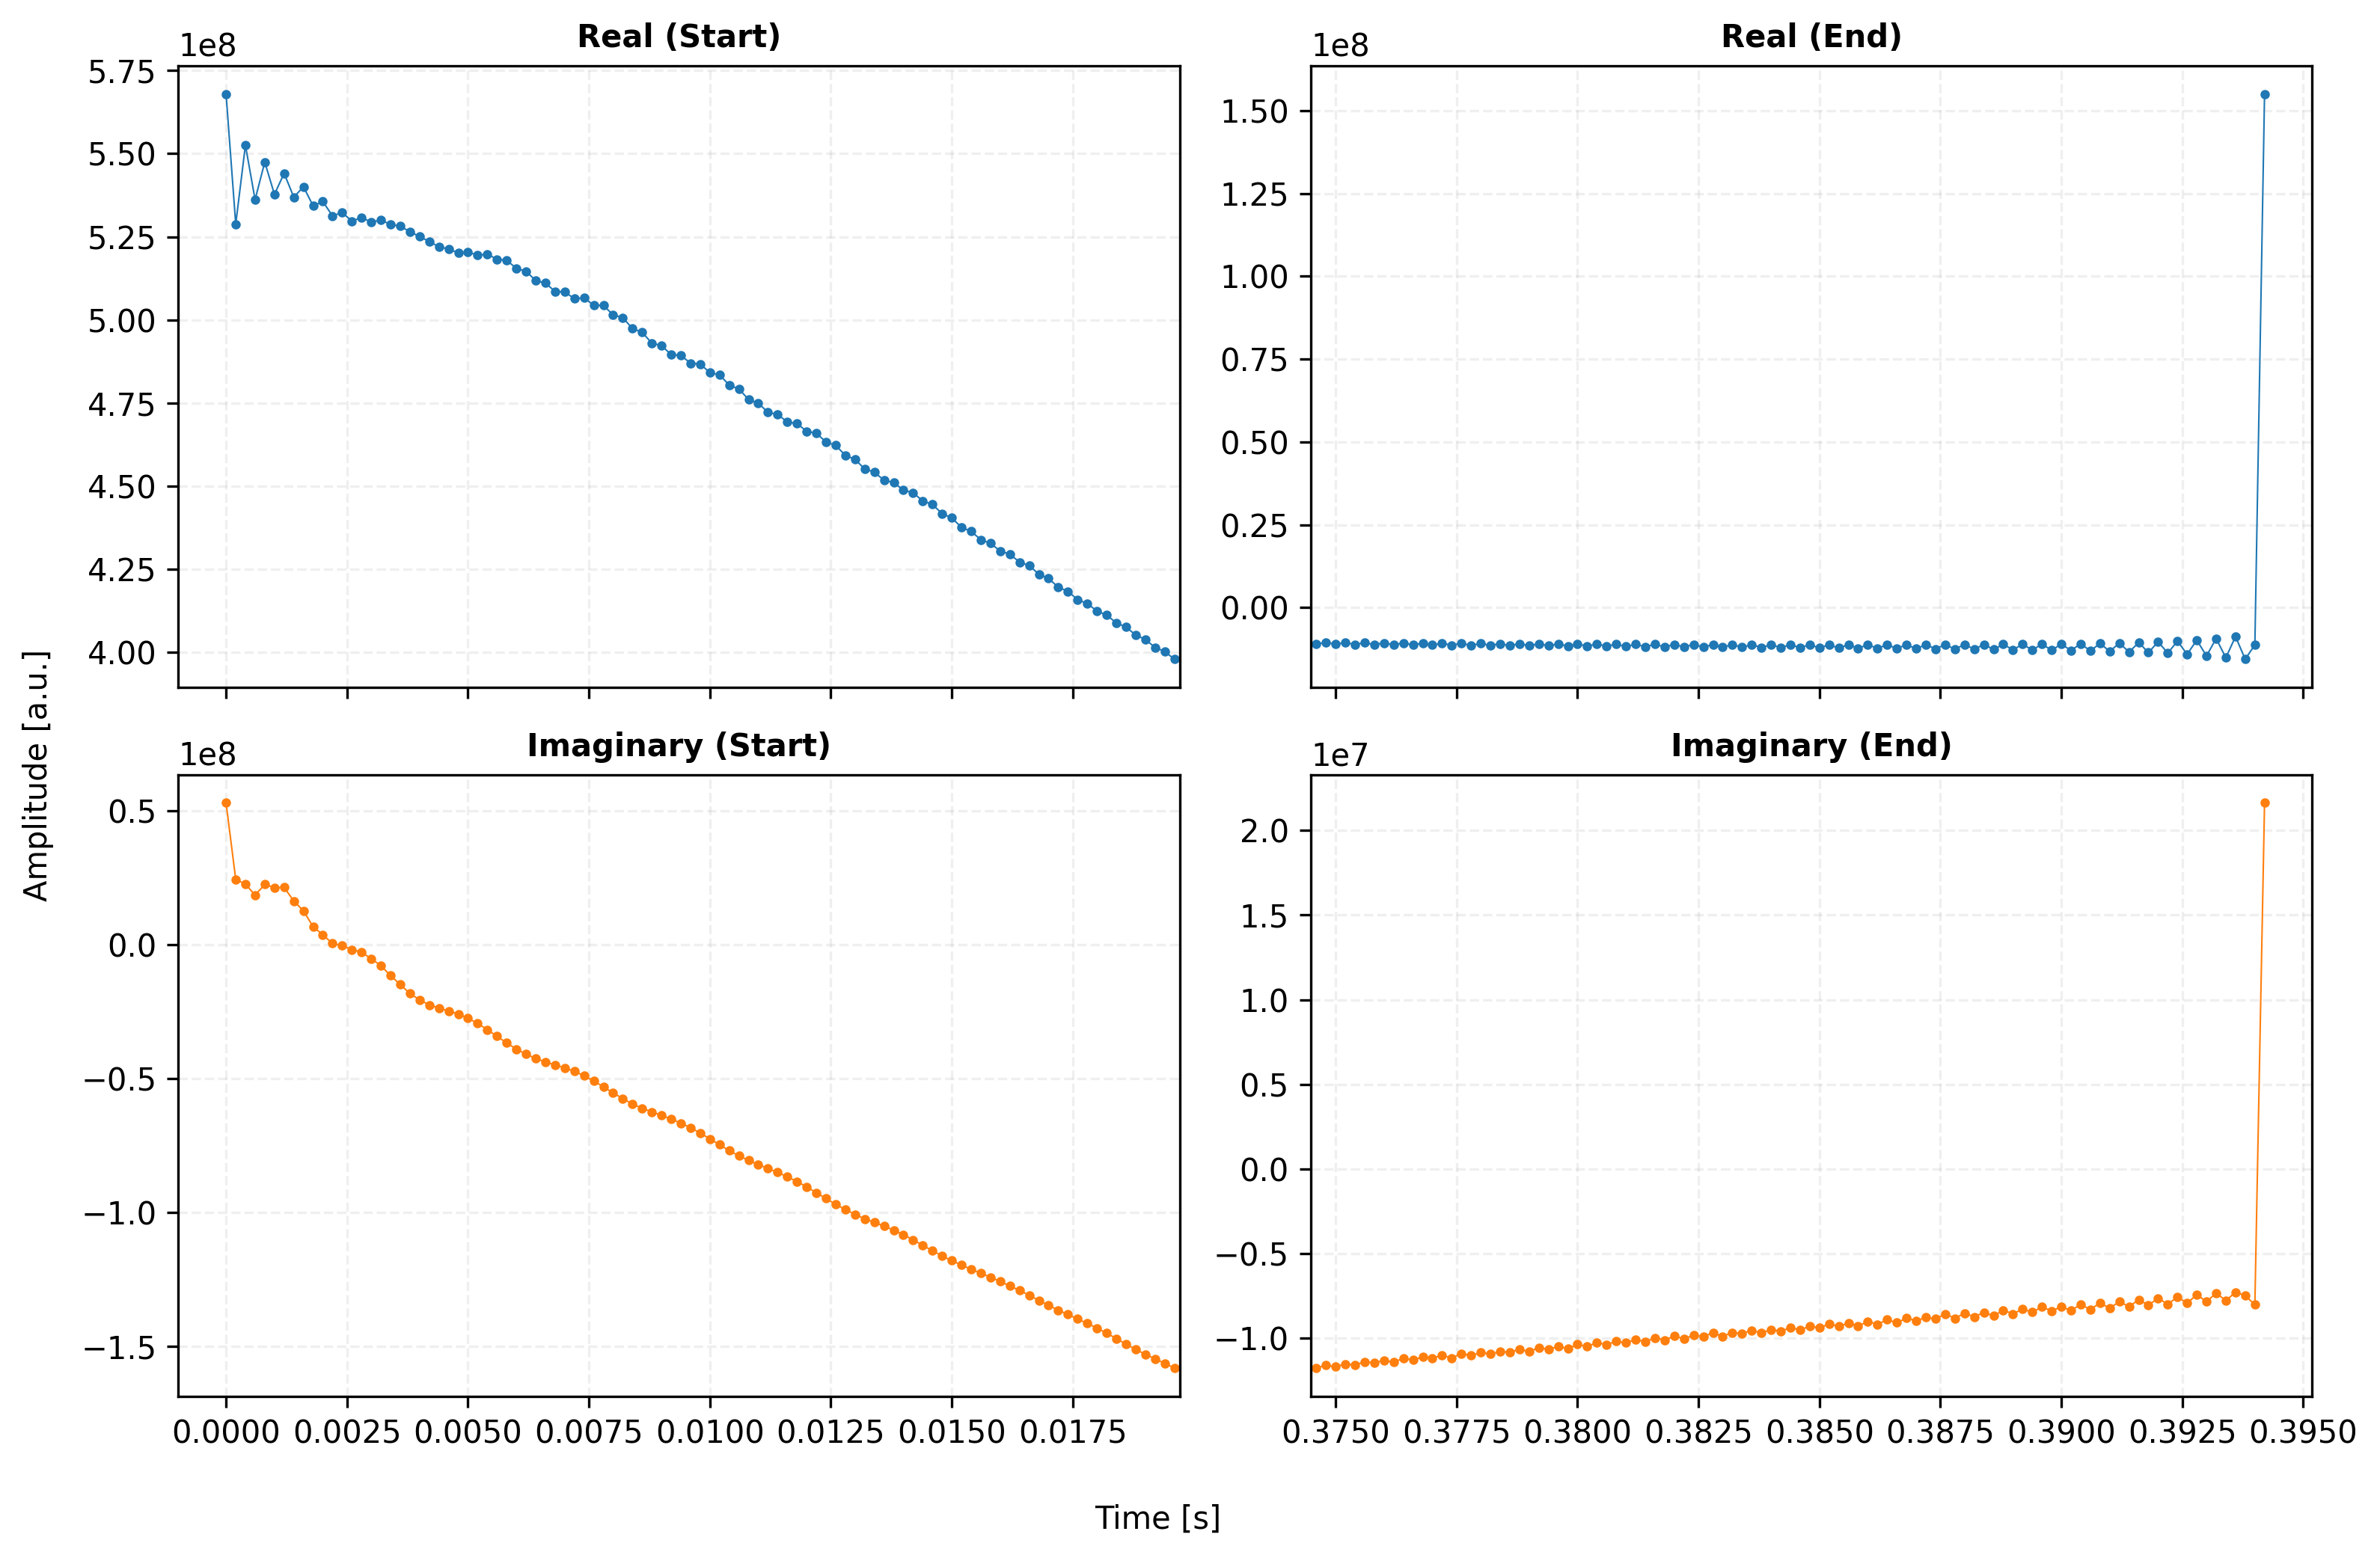

In [ ]:
# --- Configuration: Easy Adjustments ---
view_cfg = {
    "zoom_percent": 0.05,    # Window size (5% of total FID)
    "padding_percent": 0.05  # 5% padding relative to the local data range
}

# 1. Transform back to Time Domain
fid_final = spectrum.xmr.to_fid()

# 2. Setup the 2x2 grid with shared axes for decluttering
# sharex='col' -> Top and Bottom share the same time window
# sharey='row' -> Left and Right share the same amplitude scale
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex='col')
(ax_real_start, ax_real_end), (ax_imag_start, ax_imag_end) = axes

# --- Logic: Calculate Time Windows ---
t_coords = fid_final[fid_final.dims[0]]
t_min, t_max = float(t_coords.min()), float(t_coords.max())
t_total = t_max - t_min
window_len = t_total * view_cfg["zoom_percent"]

# Define the data slices for plotting
start_slice = fid_final.sel({fid_final.dims[0]: slice(t_min, t_min + window_len)})
end_slice = fid_final.sel({fid_final.dims[0]: slice(t_max - window_len, t_max)})

# --- Helper to calculate padded limits ---
def get_padded_limits(data, pad_frac):
    d_min, d_max = float(data.min()), float(data.max())
    d_range = d_max - d_min
    padding = (d_range * pad_frac) if d_range > 0 else 0.1
    return d_min - padding, d_max + padding

# --- Execute Plotting ---
# Row 1: Real
start_slice.real.plot(ax=ax_real_start, color="C0", marker='.', markersize=4, linewidth=0.5)
end_slice.real.plot(ax=ax_real_end, color="C0", marker='.', markersize=4, linewidth=0.5)

# Row 2: Imaginary
start_slice.imag.plot(ax=ax_imag_start, color="C1", marker='.', markersize=4, linewidth=0.5)
end_slice.imag.plot(ax=ax_imag_end, color="C1", marker='.', markersize=4, linewidth=0.5)

# --- Apply Dynamic Padding & Scaling ---
# X-Axis Padding (shared by columns)
ax_real_start.set_xlim(t_min - (window_len * view_cfg["padding_percent"]), t_min + window_len)
ax_real_end.set_xlim(t_max - window_len, t_max + (window_len * view_cfg["padding_percent"]))

# Y-Axis Padding (shared by rows)
# We calculate the padding based on the "Start" slice as it's the dominant signal
ax_real_start.set_ylim(get_padded_limits(start_slice.real, view_cfg["padding_percent"]))
ax_imag_start.set_ylim(get_padded_limits(start_slice.imag, view_cfg["padding_percent"]))

# --- Final Decluttering ---
titles = ["Real (Start)", "Real (End)", "Imaginary (Start)", "Imaginary (End)"]
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i], fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.2, linestyle='--')

    # Remove xarray's default auto-labels to keep it clean
    ax.set_xlabel('')
    ax.set_ylabel('')

# Add unified labels for the whole figure
fig.text(0.5, 0.02, f'Time [{fid_final.coords[fid_final.dims[0]].attrs.get("units", "s")}]', ha='center')
fig.text(0.04, 0.5, 'Amplitude [a.u.]', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 1]) # Make room for unified labels
plt.show()

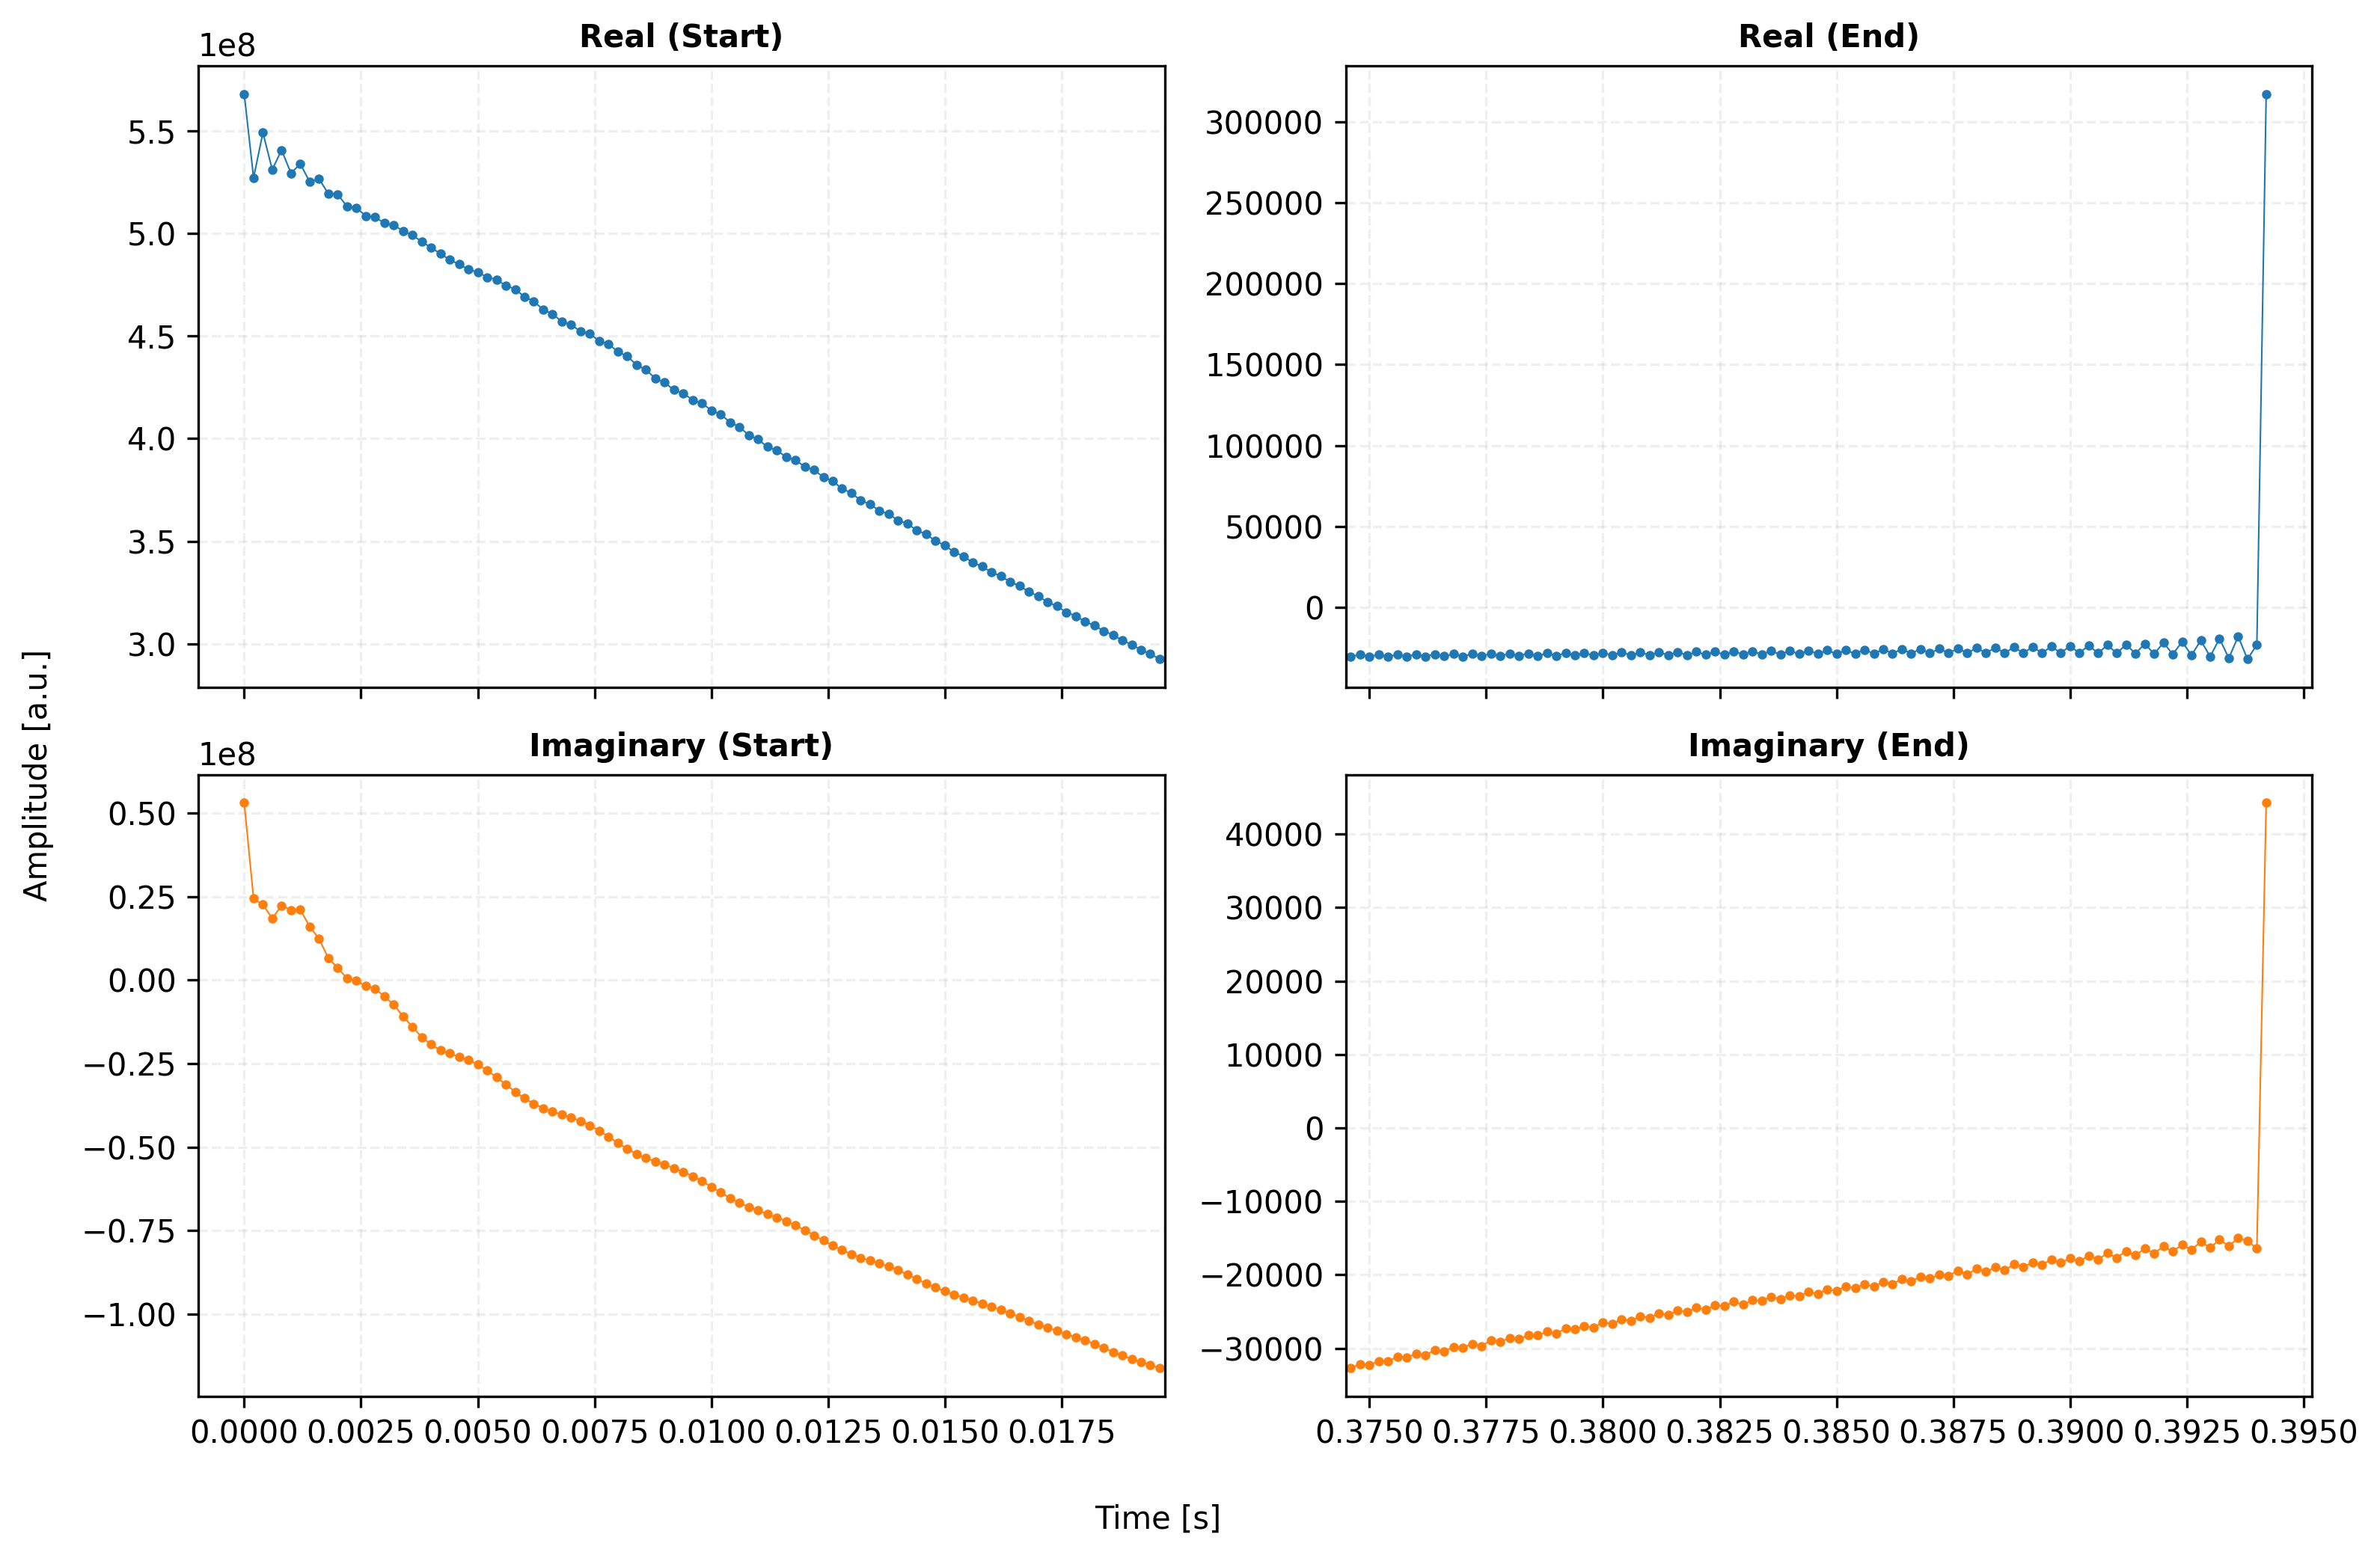

In [ ]:
# --- Configuration: Easy Adjustments ---
view_cfg = {
    "zoom_percent": 0.05,    # Window size (5% of total FID)
    "padding_percent": 0.05  # 5% padding relative to the local data range
}

# 1. Transform back to Time Domain
fid_final_apo = fid_final.xmr.apodize_exp(lb=5)

# 2. Setup the 2x2 grid with shared axes for decluttering
# sharex='col' -> Top and Bottom share the same time window
# sharey='row' -> Left and Right share the same amplitude scale
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex='col')
(ax_real_start, ax_real_end), (ax_imag_start, ax_imag_end) = axes

# --- Logic: Calculate Time Windows ---
t_coords = fid_final_apo[fid_final_apo.dims[0]]
t_min, t_max = float(t_coords.min()), float(t_coords.max())
t_total = t_max - t_min
window_len = t_total * view_cfg["zoom_percent"]

# Define the data slices for plotting
start_slice = fid_final_apo.sel({fid_final_apo.dims[0]: slice(t_min, t_min + window_len)})
end_slice = fid_final_apo.sel({fid_final_apo.dims[0]: slice(t_max - window_len, t_max)})

# --- Helper to calculate padded limits ---
def get_padded_limits(data, pad_frac):
    d_min, d_max = float(data.min()), float(data.max())
    d_range = d_max - d_min
    padding = (d_range * pad_frac) if d_range > 0 else 0.1
    return d_min - padding, d_max + padding

# --- Execute Plotting ---
# Row 1: Real
start_slice.real.plot(ax=ax_real_start, color="C0", marker='.', markersize=4, linewidth=0.5)
end_slice.real.plot(ax=ax_real_end, color="C0", marker='.', markersize=4, linewidth=0.5)

# Row 2: Imaginary
start_slice.imag.plot(ax=ax_imag_start, color="C1", marker='.', markersize=4, linewidth=0.5)
end_slice.imag.plot(ax=ax_imag_end, color="C1", marker='.', markersize=4, linewidth=0.5)

# --- Apply Dynamic Padding & Scaling ---
# X-Axis Padding (shared by columns)
ax_real_start.set_xlim(t_min - (window_len * view_cfg["padding_percent"]), t_min + window_len)
ax_real_end.set_xlim(t_max - window_len, t_max + (window_len * view_cfg["padding_percent"]))

# Y-Axis Padding (shared by rows)
# We calculate the padding based on the "Start" slice as it's the dominant signal
ax_real_start.set_ylim(get_padded_limits(start_slice.real, view_cfg["padding_percent"]))
ax_imag_start.set_ylim(get_padded_limits(start_slice.imag, view_cfg["padding_percent"]))

# --- Final Decluttering ---
titles = ["Real (Start)", "Real (End)", "Imaginary (Start)", "Imaginary (End)"]
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i], fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.2, linestyle='--')

    # Remove xarray's default auto-labels to keep it clean
    ax.set_xlabel('')
    ax.set_ylabel('')

# Add unified labels for the whole figure
fig.text(0.5, 0.02, f'Time [{fid_final_apo.coords[fid_final_apo.dims[0]].attrs.get("units", "s")}]', ha='center')
fig.text(0.04, 0.5, 'Amplitude [a.u.]', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 1]) # Make room for unified labels
plt.show()